### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 3: Predicción de una serie de tiempo caótica

En esta tarea se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

<IPython.core.display.Javascript object>


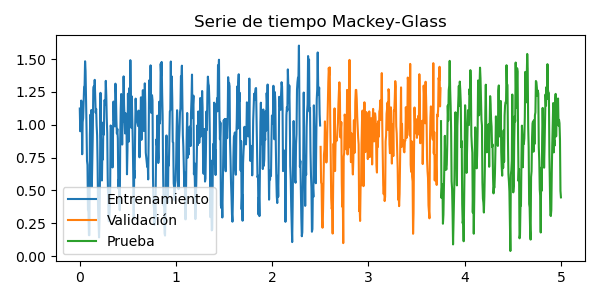

In [14]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS

1. Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el **algoritmo LMS normalizado**
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\mu$ y $L$ que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para $\mu$. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo ($\tau=17$ y $\tau=30$). Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

### 1.1 Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el algoritmo LMS normalizado

**1. Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el algoritmo LMS normalizado**

LMS es un algotimo utilizado en filtros adaptativos para encontrar los coeficientes del filtro que permiten obtener el valor mínimo esperado del cuadrado de la señal de error.
- Es un algortimo simple. 
- A diferencia del filtro de Wiener, este no requiere el conocimiento de las características estadísticas del entorno en el que opera.
- Es robusto en un sentido determinista, es decir, hay una única realización del algoritmo frente a perturbaciones ambientales desconocidas.
- No requiere de la inversión de la matriz de correlación del regresor, por lo que es más simple que RLS.

Resumen del algoritmo:

- L: número de pasos (es decir, largo del filtro)
- $\mu$: taza de aprendizaje (tamaño del paso)

**Inicialización**: elegir un valor apropiado para $\widehat{w}(0)$ si es que se dispone de información acerca del vector de coeficientes del filtro. Si no, utilizar $\widehat{w}(0) = 0$

**Data**: Obetener $u(n)=[u((n),u(n-1)),...,u(n-M+1)]$ y $d(n) = $ respuesta deseada en el tiempo

**Para calular**: $\widehat{w}(n+1)$ = estimación del vector de peso (coeficientes del filtro) de derivación en el tiempo $n+1$

**Calcular**: for n=0,1,2,.. calcular:

- $e(n) = d(n) - y(n)$ que es el error de estimación actual
- $\widehat{w}(n+1) = \widehat{w}(n) + \mu u(n)e^*(n) $ que es es el valor ótimo w 

In [19]:
# Predictor a un paso NLMS
class Filtro_NLMS:
    
    def __init__(self, L, mu, delta=1e-6, winit=None):
        self.L = L
        self.w = np.zeros(shape=(L, ))
        self.mu = mu
        self.delta = delta
        
    def update(self, un, dn):
        unorm = np.dot(un, un) + self.delta
        yn = np.dot(self.w, un)
        self.w += 2*self.mu*(dn - yn)*(un/unorm)
        return yn

In [20]:
(t_train, y_train), (t_valid, y_valid), (t_test, y_test), ymg, t = MackeyGlass(tau=17.)
#t[:500], y_obs[:500]), (t[500:750], y_obs[500:750]), (t[750:], y_obs[750:]

L = 10
nlms = Filtro_NLMS(L=L , mu=0.09)
len(y_train)

y = np.append(y_train,[y_valid,y_test])

# Entrenamiento
u_pred = np.zeros(shape=(1000, ))
for k in range(nlms.L, len(y_train)):
    u_pred[k] = nlms.update(un=y[k-nlms.L:k],dn=y[k])

# Valid
for k in range(len(y_train), 1000):
    u_pred[k] = np.dot(nlms.w,y[k-nlms.L:k])
    
# Test
for l in range(len(y_valid), len(y_test)):
    u_pred[l] = np.dot(nlms.w,y[l-nlms.L:l])
    
print("NMSE entrenamiento %0.4f, test %0.4f" %(NMSE(ymg[nlms.L:500], u_pred[nlms.L:500]), 
                                                NMSE(ymg[500:1000], u_pred[500:1000])))


ValueError: not enough values to unpack (expected 5, got 3)

### 1.2 Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\mu$ y $L$ que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para $\mu$. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.

In [18]:
def opt_lms(tau):
    
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test), ymg, t = MackeyGlass(tau=tau)
    
    y = np.append(y_train,[y_valid,y_test])
    m_r = np.linspace(0.,1.,num=1000)
    L_r = [5,10,20,30]
    for i in range(0,len(L_r)):
        for j in range(0,len(m_r)):
            nlms = Filtro_NLMS(L=L_r[i] , mu=m_r[j])
            
            u_pred = np.zeros(shape=(1000, ))
            
            for k in range(nlms.L, 500):
                u_pred[k] = nlms.update(un=y[k-nlms.L:k],dn=y[k])
            
            for l in range(500, 750):
                u_pred[l] = np.dot(nlms.w,y[l-nlms.L:l])

            mr = (NMSE(ymg[500:750], u_pred[500:750]))
            
            if(i==0 and j ==0):
                mse_min = mr
                m_min = m_r[j]
            
            if(mse_min>mr):
                mse_min = mr
                m_min = m_r[j]

        print("t= ",tau, "L= ,",L_r[i]," el MSE mímimo es :",mse_min ," y con mu: ", m_min)

In [11]:
opt_lms(17.)

ValueError: not enough values to unpack (expected 5, got 3)

In [12]:
# Utilizando L =30 y mu=0.074 que resultó dar menor MSE
L = 30
mu = 0.074
nlms = Filtro_NLMS(L=L , mu=mu)

# Train
u_pred = np.zeros(shape=(1000, ))
for k in range(nlms.L, 500):
    u_pred[k] = nlms.update(un=y[k-nlms.L:k],dn=y[k])

# Test
for l in range(500,1000):
    u_pred[l] = np.dot(nlms.w,y[l-nlms.L:l])
    
print("NMSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[nlms.L:500], u_pred[nlms.L:500]), 
                                                NMSE(ymg[500:], u_pred[500:])))


NameError: name 'y' is not defined

In [13]:
def upd(mu, L):
    
    fig, ax = plt.subplots(3, figsize=(9, 5), tight_layout=True)
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test), ymg, t = MackeyGlass(tau=17.)
    nlms = Filtro_NLMS(L=L , mu=mu)
    
    y = np.append(y_train,[y_valid,y_test])

    u_pred = np.zeros(shape=(1000, ))
    for k in range(nlms.L, len(y_train)):
        u_pred[k] = nlms.update(un=y[k-nlms.L:k],dn=y[k])

    # Prueba
    for k in range(500, 1000):
        u_pred[k] = np.dot(nlms.w,y[k-nlms.L:k])
        

    ax[0].plot(t ,y,'k.', alpha=0.5, label='Observado'); ax[0].legend(); 
    ax[1].plot(t , ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco', c='y'); 
    ax[1].plot(t[:500], u_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:750], u_pred[500:750], alpha=0.75, lw=2, label='Predicho valid');
    ax[1].plot(t[750:], u_pred[750:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - u_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:750], (ymg[500:750] - u_pred[500:750])**2, label='Error cuadrático valid');
    ax[2].plot(t[750:], (ymg[750:] - u_pred[750:])**2, label='Error cuadrático test'); ax[2].legend();
    fig.suptitle("\u03C4= "+str(17)+",   L ="+str(L)+",   \u03BC= "+str(mu), fontsize=16)
    
    print("MSE entrenamiento %0.4f, validación %0.4f, prueba %0.4f" %(NMSE(ymg[nlms.L:500], u_pred[nlms.L:500]), 
                                                NMSE(ymg[500:750], u_pred[500:750]),NMSE(ymg[750:], u_pred[750:])))

interact(upd, mu=(0.0,1.0,0.01),L=(0,30,5))



NameError: name 'interact' is not defined

Para mu=0.02

- (L = 5): El MSE de entrenamiento está cercano a 1000, mientras que los de validación y prueba se muestran aproximados entre 333.

- (L = 10): El MSE de entrenamiento es de 646.15, mientras que el de validación y pruebas son, respectivamente, 164.89 y 180.82

- (L = 15): EL MSE de entrenamiento es de 636.8327, mientras que el de validación y prueba son de 147.781 y 151.2214 respectivamente

- (L = 30): El MSE de entrenamiento es de 626.8830, mientras que el de validación y prueba son de 151.222 y 161.0010 respectivamente.

El MSE 

### 1.3 Repita el paso anterior para el caso $\tau = 30$

In [21]:
(t_train, y_train), (t_valid, y_valid), (t_test, y_test), ymg, t = MackeyGlass(tau=30.)

ValueError: not enough values to unpack (expected 5, got 3)

In [22]:
opt_lms(30.)

ValueError: not enough values to unpack (expected 5, got 3)

In [23]:
#Utilizando 
L = 20
nlms = Filtro_NLMS(L=L , mu=0.02)

# Entrenamiento
u_pred = np.zeros(shape=(1000, ))
for k in range(nlms.L, len(y_train)):
    u_pred[k] = nlms.update(un=y_train[k-nlms.L:k],dn=y_train[k])

# Prueba
for k in range(len(y_train), len(y_valid)):
    u_pred[k] = np.dot(nlms.w,y_valid[k-nlms.L:k])

# Test
for l in range(len(y_valid),len(y_test)):
    u_pred[l] = np.dot(nlms.w,y_test[l-nlms.L:l])
    
print("NMSE entrenamiento %0.4f, validación %0.4f, prueba %0.4f" %(NMSE(ymg[nlms.L:500], u_pred[nlms.L:500]), 
                                                NMSE(ymg[500:750], u_pred[500:750]),NMSE(ymg[750:], u_pred[750:])))



NameError: name 'ymg' is not defined

In [24]:
def upd(mu, L):
    
    fig, ax = plt.subplots(3, figsize=(9, 7), tight_layout=True)
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test),ymg,t = MackeyGlass(tau=30.)
    nlms = Filtro_NLMS(L=L , mu=mu)

    
    u_pred = np.zeros(shape=(1000, ))
    for k in range(nlms.L, len(y_train)):
        u_pred[k] = nlms.update(un=y_train[k-nlms.L:k],dn=y_train[k])

    for k in range(len(y_train), len(y_valid)):
        u_pred[k] = np.dot(nlms.w,y_valid[k-nlms.L:k])

    for l in range(len(y_valid),len(y_test)):
        u_pred[l] = np.dot(nlms.w,y_test[l-nlms.L:l])


    y = np.append(y_test, np.append(y_train, y_valid))

    ax[0].plot(t ,y,'k.', alpha=0.5, label='Observado'); ax[0].legend(); 
    ax[1].plot(t , ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco', c='y'); 
    ax[1].plot(t[:500], u_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:750], u_pred[500:750], alpha=0.75, lw=2, label='Predicho valid');
    ax[1].plot(t[750:], u_pred[750:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - u_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:750], (ymg[500:750] - u_pred[500:750])**2, label='Error cuadrático valid');
    ax[2].plot(t[750:], (ymg[750:] - u_pred[750:])**2, label='Error cuadrático test'); ax[2].legend();
    fig.suptitle("\u03C4= "+str(17)+",   L ="+str(L)+",   \u03BC= "+str(mu), fontsize=16)
    
    print("MSE entrenamiento %0.4f, validación %0.4f, prueba %0.4f" %(NMSE(ymg[nlms.L:500], u_pred[nlms.L:500]), 
                                                NMSE(ymg[500:750], u_pred[500:750]),NMSE(ymg[750:], u_pred[750:])))

interact(upd, mu=(0.0,1.0,0.01),L=(0,30,5))



NameError: name 'interact' is not defined

### 1.4 Compare los resultados obtenidos con cada serie de tiempo ($\tau=17$ y $\tau=30$). Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (45%) Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

### 2.1 Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS

In [25]:
# Predictor a un paso
class Filtro_RLS:
    
    def __init__(self, L, beta=0.99, lamb=1e-2):
        self.L = L
        self.w = np.zeros(shape=(L, ))
        self.beta = beta
        self.lamb = lamb
        self.Phi_inv = lamb*np.eye(L)
        
    def update(self, un, dn):
        pi = np.dot(un.T, self.Phi_inv)
        kn = pi.T/(self.beta + np.inner(pi, un))
        error = dn - np.dot(self.w, un)
        self.w += kn*error
        self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
        return np.dot(self.w, un)

In [26]:
L = 20
rls = Filtro_RLS(L=L)

# Train
u_pred = np.zeros(shape=(len(y_obs), ))

for k in range(rls.L, 500):
    u_pred[k] = rls.update(dn=y_train, un=y_train[k-rls.L:k])
    
# Valid
for k in range(500, 750):
    u_pred[k] = np.dot(rls.w,y_valid[k-rls.L:k])
    
# Test
for k in range(750,1000):
    u_pred[k] = np.dot(rls.w,y_obs[k-rls.L:k])
    
print("MSE entrenamiento %0.4f, valid %0.4f, prueba %0.4f" %(NMSE(ymg[rls.L:500], u_pred[rls.L:500]), 
                                                              NMSE(ymg[500:750], u_pred[500:750]), 
                                                              NMSE(ymg[750:], u_pred[750:])))

NameError: name 'y_obs' is not defined

### 2.2 Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.

In [27]:
def upd_rls(beta, L):
    
    fig, ax = plt.subplots(3, figsize=(9, 7), tight_layout=True)
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
    nlms = Filtro_RLS(L=L , beta=beta)

    u_pred = np.zeros(shape=(len(y_obs), ))
    u_pred = np.zeros(shape=(len(y_obs), ))

    for k in range(rls.L, 500):
        u_pred[k] = rls.update(dn=y_obs[k], un=y_obs[k-rls.L:k])

    for k in range(500, 750):
        u_pred[k] = np.dot(rls.w,y_obs[k-rls.L:k])

    for k in range(750,1000):
        u_pred[k] = np.dot(rls.w,y_obs[k-rls.L:k])
    
    ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend(); 
    ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco', c='y'); 
    ax[1].plot(t[:500], u_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:750], u_pred[500:750], alpha=0.75, lw=2, label='Predicho valid');
    ax[1].plot(t[750:], u_pred[750:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - u_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:750], (ymg[500:750] - u_pred[500:750])**2, label='Error cuadrático valid');
    ax[2].plot(t[750:], (ymg[750:] - u_pred[750:])**2, label='Error cuadrático test'); ax[2].legend();
    fig.suptitle("\u03C4= "+str(30)+",   L ="+str(L)+",   \u03B2= "+str(beta), fontsize=16)
    
    print("MSE entrenamiento %0.4f, validación %0.4f, prueba %0.4f" %(NMSE(ymg[nlms.L:500], u_pred[nlms.L:500]), 
                                                NMSE(ymg[500:750], u_pred[500:750]),NMSE(ymg[750:], u_pred[750:])))



interact(upd_rls, beta=(0.0,1.0,0.01), L=(0,30,5))

NameError: name 'interact' is not defined

### 2.3  Repita el paso anterior para el caso $\tau = 30$

In [28]:
def upd_rls(beta, L):
    
    fig, ax = plt.subplots(3, figsize=(9, 7), tight_layout=True)
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
    nlms = Filtro_RLS(L=L , beta=beta)

    u_pred = np.zeros(shape=(len(y_obs), ))
    u_pred = np.zeros(shape=(len(y_obs), ))

    for k in range(rls.L, 500):
        u_pred[k] = rls.update(dn=y_obs[k], un=y_obs[k-rls.L:k])

    for k in range(500, 750):
        u_pred[k] = np.dot(rls.w,y_obs[k-rls.L:k])

    for k in range(750,1000):
        u_pred[k] = np.dot(rls.w,y_obs[k-rls.L:k])
    
    ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend(); 
    ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco', c='y'); 
    ax[1].plot(t[:500], u_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:750], u_pred[500:750], alpha=0.75, lw=2, label='Predicho valid');
    ax[1].plot(t[750:], u_pred[750:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - u_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:750], (ymg[500:750] - u_pred[500:750])**2, label='Error cuadrático valid');
    ax[2].plot(t[750:], (ymg[750:] - u_pred[750:])**2, label='Error cuadrático test'); ax[2].legend();
    fig.suptitle("\u03C4= "+str(30)+",   L ="+str(L)+",   \u03B2= "+str(beta), fontsize=16)
    
    print("MSE entrenamiento %0.4f, validación %0.4f, prueba %0.4f" %(NMSE(ymg[nlms.L:500], u_pred[nlms.L:500]), 
                                                NMSE(ymg[500:750], u_pred[500:750]),NMSE(ymg[750:], u_pred[750:])))



interact(upd_rls, beta=(0.0,1.0,0.01), L=(0,30,5))

NameError: name 'interact' is not defined

### 2.4 Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta


R: El algoritmo RLS el mucho mas rapido para converger que el algoritmo LMS, pero presentan problemas en la insertabilidad, y utilizacion de lenguaje mas complejo. Debido a que el algoritmo LMS considera solo el error cuadratico inmediato, contrario a RLS que utiliza un historial de errores, esto lo hace tener mayor calidad de prediccion y adaptacion a los cambios bruscos. El algoritmo LMS puede  ser una solución sencilla cuando se trabaja con  señales que cambian muy lentamente con el tiempo, ya que es lento para adaptarse y se desarrolla de forma lineal, en cambio el algoritmo RLS se desarrolla de forma recursiva.